In [1]:
import json
import numpy as np
from pp_utils import TimeStepStats, LinearSolveStats
from matplotlib import pyplot as plt
from plot_utils import *

def load_data(path) -> Sequence[TimeStepStats]:
    with open(path, "r") as f:
        payload = json.load(f)
    return [TimeStepStats.from_json(x) for x in payload]

dataset = {
    'baseline': load_data("../stats/fpm_0_open.json"),
    # 'rprec': load_data("../stats/fpm_0_open_rprec.json"),

    # 'baseline': load_data("../stats/fpm_0_sliding.json"),
    # 'rprec': load_data("../stats/fpm_0_sliding_rprec.json"),

    # 'baseline': load_data("../stats/fpm_2_sliding.json"),
}
data = dataset['baseline']

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


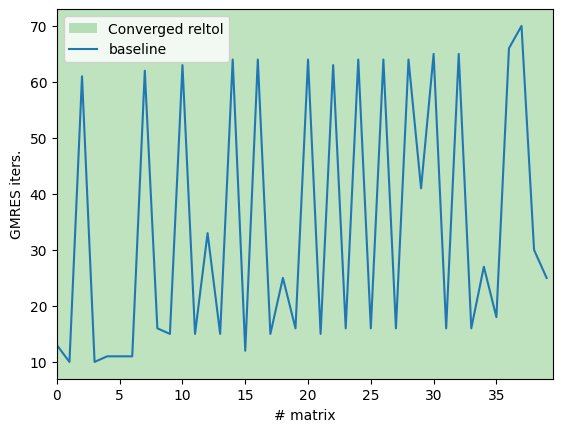

In [2]:
# %matplotlib ipympl
color_converged_reason(data)
for name, data in dataset.items():
    plt.plot(get_gmres_iterations(data), label=name)
    plt.ylabel('GMRES iters.')
    plt.xlabel('# matrix')
    # plt.yscale('log')
plt.legend()

In [14]:
get_gmres_iterations(data)[10]

63

In [17]:
import scipy.sparse
from pathlib import Path
from plot_utils import *


def load_matrix_rhs(data: Sequence[TimeStepStats], idx: int):
    flat_data: list[LinearSolveStats] = [y for x in data for y in x.linear_solves]
    load_dir = Path('../matrices')
    mat = scipy.sparse.load_npz(load_dir / flat_data[idx].matrix_id)
    rhs = np.load(load_dir / flat_data[idx].rhs_id)
    return mat, rhs

mat, rhs = load_matrix_rhs(data, 10)

In [45]:
import porepy as pp
import numpy as np   
from mat_utils import *
from plot_utils import *
from fpm_0 import make_model

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


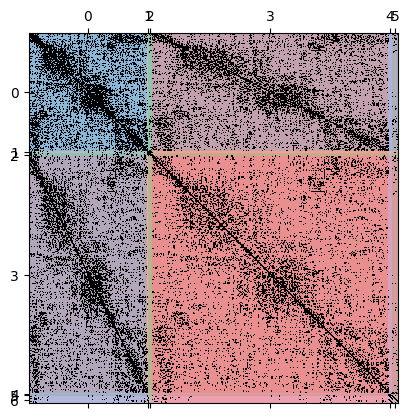

In [23]:
dim_max = model.mdg.dim_max()
sd_ambient = model.mdg.subdomains(dim=dim_max)
sd_lower = [k for i in reversed(range(0, dim_max)) for k in model.mdg.subdomains(dim=i)]
sd_frac = model.mdg.subdomains(dim=dim_max - 1)
intf = model.mdg.interfaces()
intf_frac = model.mdg.interfaces(dim=dim_max - 1)

var_idx = get_variables_indices(
    variable_to_idx=make_variable_to_idx(model),
    md_variables_groups=[
        [model.pressure(sd_ambient)],
        [model.displacement(sd_ambient)],
        [model.pressure(sd_lower)],
        [model.interface_darcy_flux(intf)],
        [model.contact_traction(sd_frac)],
        [model.interface_displacement(intf_frac)],
    ],
)

eq_idx = get_equations_indices(
    equation_to_idx=make_equation_to_idx(model),
    equations_group_order=[
        [("mass_balance_equation", sd_ambient)],  # 0
        [("momentum_balance_equation", sd_ambient)],  # 1
        [("mass_balance_equation", sd_lower)],  # 2
        [("interface_darcy_flux_equation", intf)],  # 3
        [
            ("normal_fracture_deformation_equation", sd_lower),  # 4
            ("tangential_fracture_deformation_equation", sd_lower),
        ],
        [("interface_force_balance_equation", intf)],  # 5
    ],
)

from block_matrix import BlockMatrixStorage

J = BlockMatrixStorage(mat=mat, row_idx=eq_dofs, col_idx=var_dofs, groups_row=eq_idx, groups_col=var_idx)
J.color_spy()

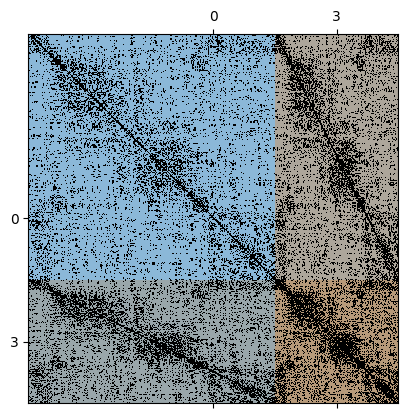

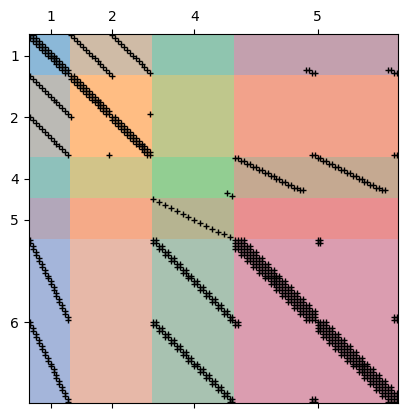

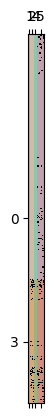

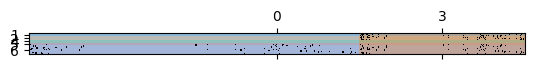

In [24]:
flow = [0]
mech = [1]
others = [2, 3, 4, 5]
mechflow = mech + flow
Omega = J[mechflow, mechflow]
Phi = J[mechflow, others]
Psi = J[others, mechflow]
F = J[others, others]
Omega.color_spy(); plt.show()
F.color_spy(); plt.show()
Phi.color_spy(); plt.show()
Psi.color_spy(); plt.show()

In [25]:
F_inv = inv(F.mat)
stab = Phi.mat @ F_inv @ Psi.mat
Omega_p = Omega.copy()
Omega_p.mat -= stab

Solve  took: 0.0


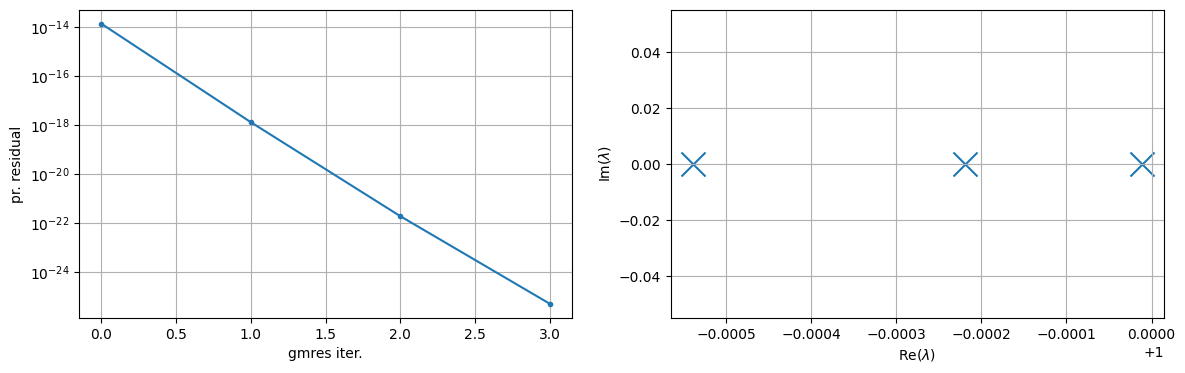

In [9]:
S_Ap = Omega_p[flow, flow]
S_Ap.mat += get_fixed_stress_stabilization(model=model)

S_Ap_amg = PetscAMGFlow(S_Ap.mat)
rhs_S_Ap = S_Ap.local_rhs(rhs)
solve_petsc(S_Ap.mat, S_Ap_amg, rhs=rhs_S_Ap)

Solve  took: 0.02


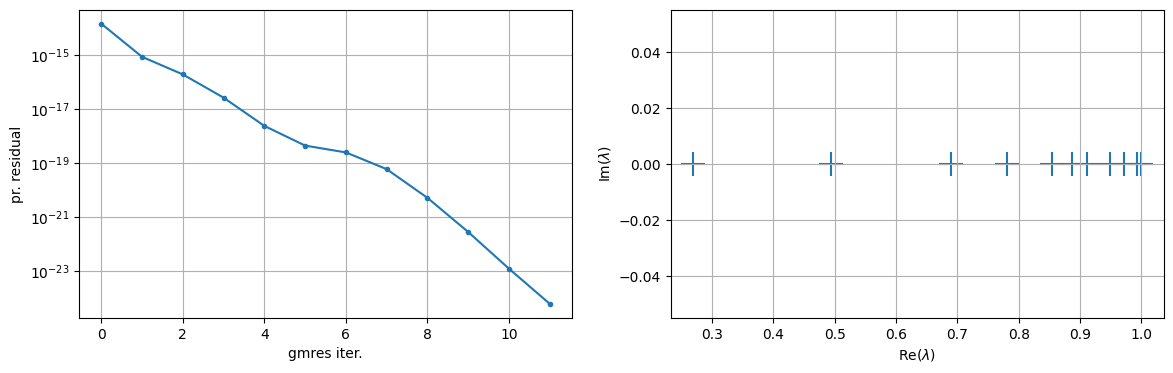

In [10]:
Bp = Omega_p[mech, mech]

Bp_amg = PetscAMGMechanics(dim=model.nd, mat=Bp.mat)
rhs_Bp = Bp.local_rhs(rhs)
solve_petsc(Bp.mat, Bp_amg, rhs=rhs_Bp)

Solve  took: 0.19


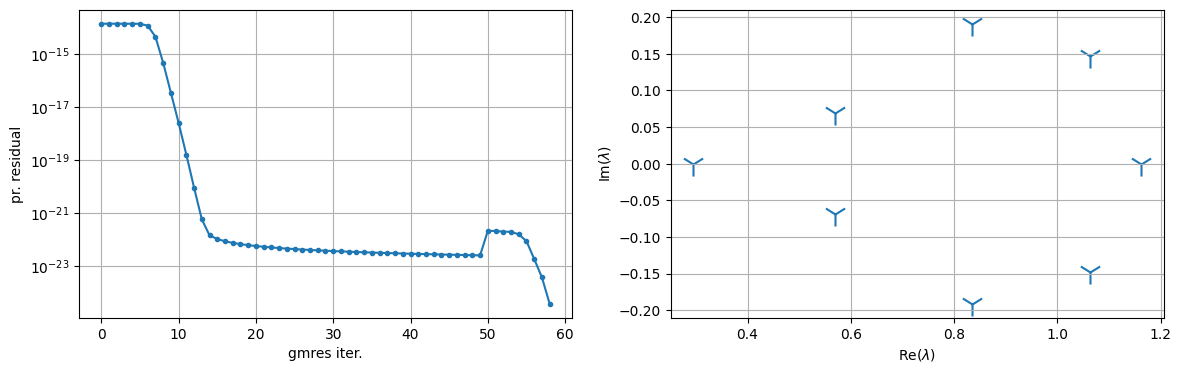

In [11]:
omega_inv = OmegaInv(solve_momentum=Bp_amg, solve_mass=S_Ap_amg, C1=Omega_p[flow, mech].mat, C2=Omega_p[mech, flow].mat)

solve_petsc(Omega_p.mat, omega_inv, rhs=Omega_p.local_rhs(rhs))

Solve  took: 0.22


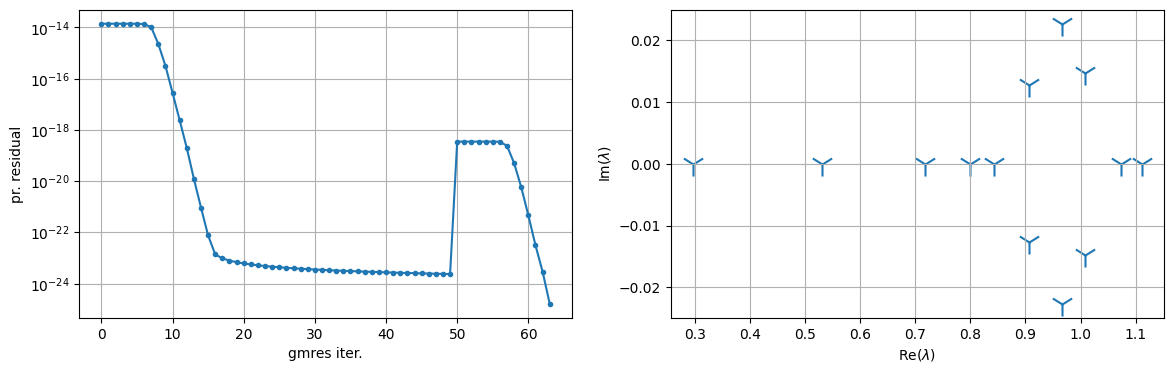

In [51]:
prec = UpperBlockPreconditioner(F_inv=F_inv, Omega_inv=omega_inv, Phi=Psi.mat)
mat_reordered = J[others + mechflow, others + mechflow]
# mat_reordered.color_spy()
solve_petsc(mat_reordered.mat, prec, model.permutation @ rhs)

Solve  took: 0.23


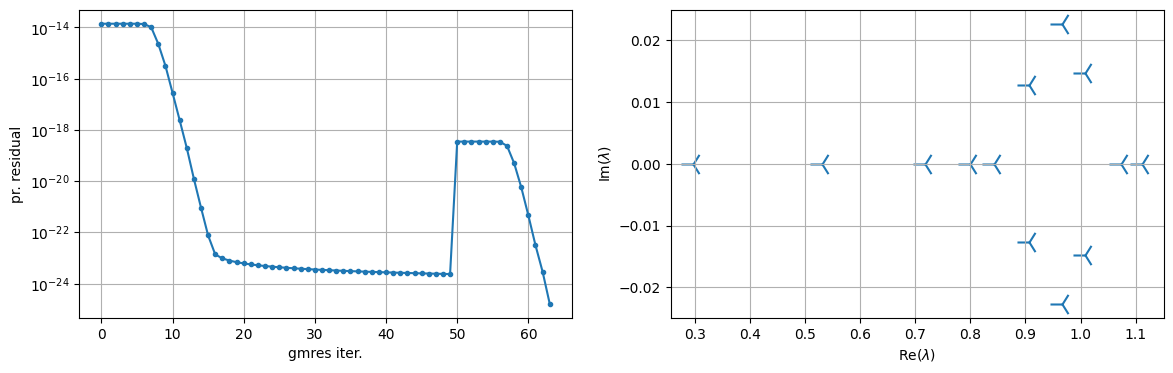

In [69]:
solve_petsc(perm_mat, prec, rhs=mat_reordered.local_rhs(rhs))